In [1]:
import numpy as np
import matplotlib.pyplot as plt
from recordtype import recordtype
import json
import pathlib
import os

import dadrah.kfold_pipeline.kfold_string_constants as kstco

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
Parameters = recordtype('Parameters','qr_run_n, env_run_n')
env_run_n=0
params_x0 = Parameters(qr_run_n=416,env_run_n=env_run_n)
params_x100 = Parameters(qr_run_n=616,env_run_n=env_run_n)

In [3]:
sig_id_dir = {
    616: 'Grs35na',
    716: 'Grs15br',
    816: 'Grs25na'
}

In [4]:
kfold_n = 5
quantiles = [0.3, 0.5, 0.7, 0.9]
sig_id =  sig_id_dir[params_x100.qr_run_n]
fig_dir = '../fig/env_analysis/multi_env/{}_{}_vs_{}_{}'.format(params_x0.qr_run_n,env_run_n,params_x100.qr_run_n,env_run_n)
pathlib.Path(fig_dir).mkdir(parents=True, exist_ok=True)

In [5]:
env_x0 = kstco.get_envelope_dir(params_x0) # load envelope path
env_x100 = kstco.get_envelope_dir(params_x100)

In [6]:
bin_idx, mu_idx, rmse_idx, min_idx, max_idx = range(5)

In [7]:
# read xsec0 envelope 
envelope_per_fold_x0 = {}
for k in range(1,kfold_n+2): # k: 1-6
    envelope_json_path = kstco.get_envelope_file(params_x0,k)
    ff = open(envelope_json_path)
    envelope_per_fold_x0['fold_{}'.format(k)] = json.load(ff)

In [8]:
# read xsec100 envelope 
envelope_per_fold_x100 = {}
for k in range(1,kfold_n+2): # k: 1-6
    envelope_json_path = kstco.get_envelope_file(params_x100,k)
    ff = open(envelope_json_path)
    envelope_per_fold_x100['fold_{}'.format(k)] = json.load(ff)

In [11]:
bins = np.asarray(envelope_per_fold_x0['fold_1']['0.5'])[:,bin_idx]
mjj_max = 5500.

vline_x_dir = {'Grs15br': 1500, 'Grs35na': 3500}
vline_x = vline_x_dir[sig_id]

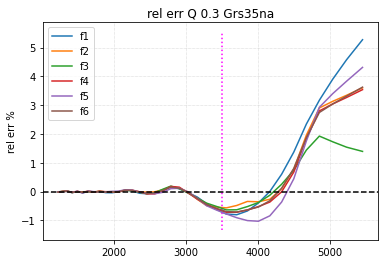

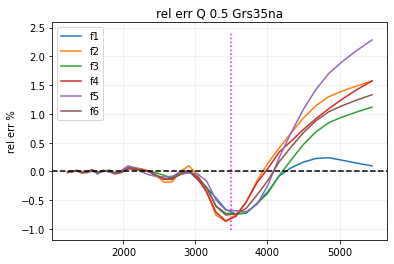

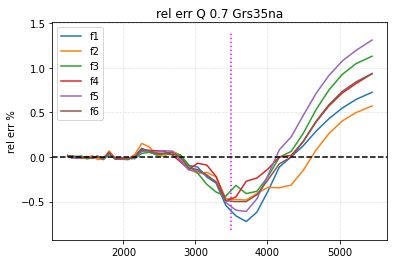

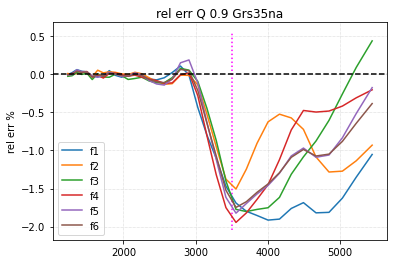

In [12]:
# plot relative err
for q in quantiles:
    fig = plt.figure()
    q_str = str(q)
    plt.title('rel err Q {} {}'.format(q_str,sig_id))
    for k in range(1,kfold_n+2):
        fold_str = 'fold_{}'.format(k)
        mu_x0 = np.asarray(envelope_per_fold_x0[fold_str][q_str])[:,mu_idx][bins<mjj_max]
        mu_x100 = np.asarray(envelope_per_fold_x100[fold_str][q_str])[:,mu_idx][bins<mjj_max]
        errs = ((mu_x0-mu_x100)/mu_x0)*100
        plt.plot(bins[bins<mjj_max],errs, label='f'+str(k))
    plt.grid(True, linestyle='dotted',linewidth=0.5)
    plt.ylabel('rel err %')
    plt.axhline(y=0, linestyle='--', c='k')
    ymin, ymax = plt.gca().get_ylim()
    plt.vlines(vline_x,ymin=ymin*0.99,ymax=ymax*0.99,colors='magenta',linestyle='dotted')
    plt.legend()
    plt.savefig(os.path.join(fig_dir,'rel_err_q'+str(int(q*100))+'.pdf'))
    plt.show()
    plt.close(fig)

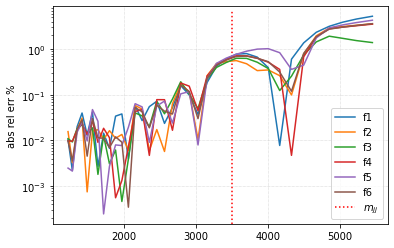

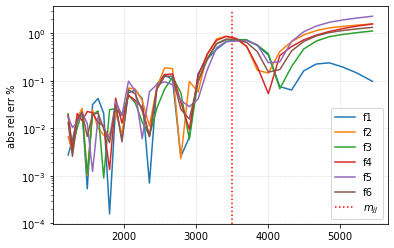

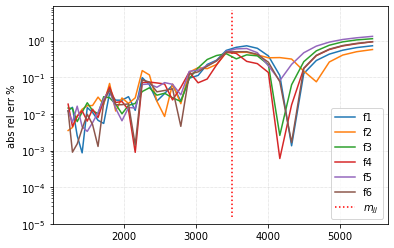

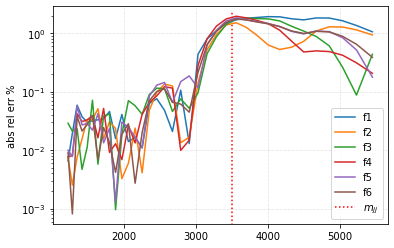

In [13]:
# plot absolute err
for q in quantiles:
    fig = plt.figure()
    q_str = str(q)
    #plt.title('rel err Q {} {}'.format(q_str,sig_id))
    for k in range(1,kfold_n+2):
        fold_str = 'fold_{}'.format(k)
        mu_x0 = np.asarray(envelope_per_fold_x0[fold_str][q_str])[:,mu_idx][bins<mjj_max]
        mu_x100 = np.asarray(envelope_per_fold_x100[fold_str][q_str])[:,mu_idx][bins<mjj_max]
        plt.plot(bins[bins<mjj_max],np.abs((mu_x0-mu_x100)/mu_x0)*100, label='f'+str(k))
    plt.grid(True, linestyle='dotted',linewidth=0.5)
    plt.axhline(y=0, linestyle='--', c='k')
    plt.yscale('log')
    ymin, ymax = plt.gca().get_ylim()
    plt.vlines(vline_x,ymin=max(ymin*0.8,1.5e-5),ymax=ymax*0.8,colors='r',linestyle='dotted', label=r'$m_{jj}$')
    plt.ylim([max(ymin,1e-5),ymax])
    plt.ylabel('abs rel err %')
    plt.legend()
    plt.savefig(os.path.join(fig_dir,'abs_rel_err_q'+str(int(q*100))+'.pdf'))

In [14]:
xlog = True

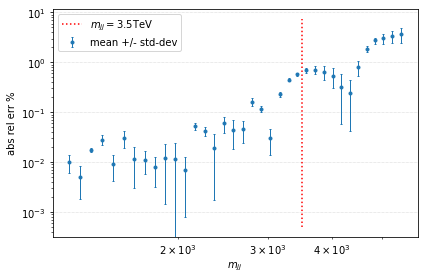

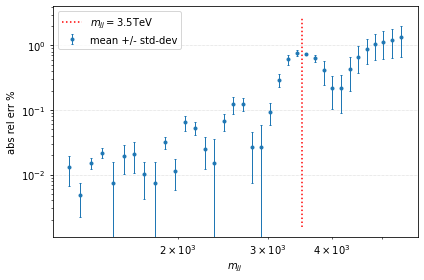

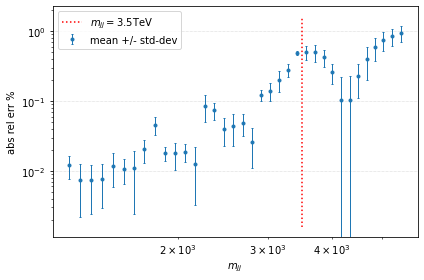

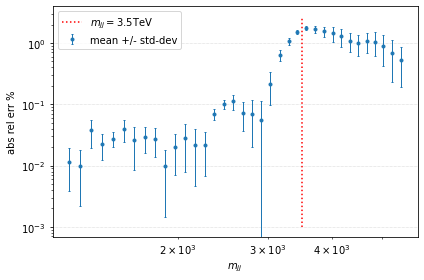

In [15]:
# plot absolute err mean & errorbars
for q in quantiles:
    fig = plt.figure()
    q_str = str(q)
    #plt.title('rel err Q {} {}'.format(q_str,sig_id))
    errs = []
    for k in range(1,kfold_n+2):
        fold_str = 'fold_{}'.format(k)
        mu_x0 = np.asarray(envelope_per_fold_x0[fold_str][q_str])[:,mu_idx][bins<mjj_max]
        mu_x100 = np.asarray(envelope_per_fold_x100[fold_str][q_str])[:,mu_idx][bins<mjj_max]
        errs.append(np.abs((mu_x0-mu_x100)/mu_x0)*100)
    errs = np.asarray(errs)
    plt.errorbar(x=bins[bins<mjj_max], y=np.mean(errs,axis=0), yerr=np.std(errs,axis=0), elinewidth=1., linestyle='none', marker='.', capsize=1, label='mean +/- std-dev')
    plt.grid(True, linestyle='dotted',linewidth=0.5)
    plt.yscale('log')
    ymin, ymax = plt.gca().get_ylim()
    plt.vlines(vline_x,ymin=ymin*0.99,ymax=ymax*0.99,colors='r',linestyle='dotted', label=r'$m_{jj}=$'+str(vline_x/1000)+'TeV')
    if xlog:
        plt.xscale('log')
    plt.ylabel('abs rel err %')
    plt.xlabel(r'$m_{jj}$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,'errorbar_log_abs_err_q'+str(int(q*100))+('_xlog' if xlog else '')+'.pdf'))

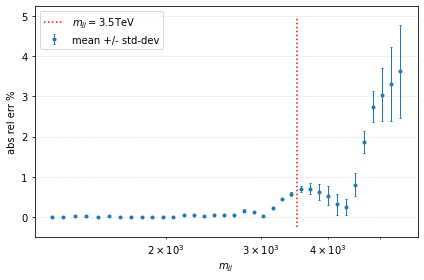

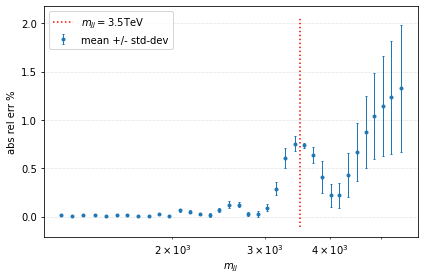

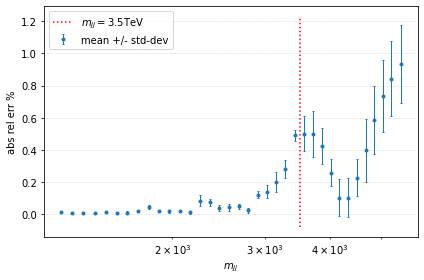

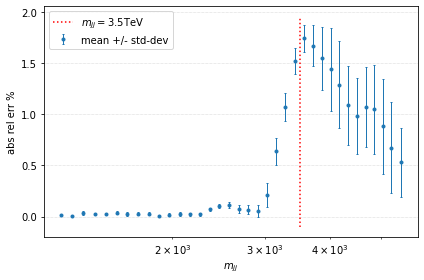

In [16]:
# plot absolute err mean & errorbars
for q in quantiles:
    fig = plt.figure()
    q_str = str(q)
    #plt.title('rel err Q {} {}'.format(q_str,sig_id))
    errs = []
    for k in range(1,kfold_n+2):
        fold_str = 'fold_{}'.format(k)
        mu_x0 = np.asarray(envelope_per_fold_x0[fold_str][q_str])[:,mu_idx][bins<mjj_max]
        mu_x100 = np.asarray(envelope_per_fold_x100[fold_str][q_str])[:,mu_idx][bins<mjj_max]
        errs.append(np.abs((mu_x0-mu_x100)/mu_x0)*100)
    errs = np.asarray(errs)
    plt.errorbar(x=bins[bins<mjj_max], y=np.mean(errs,axis=0), yerr=np.std(errs,axis=0), elinewidth=1., linestyle='none', marker='.', capsize=1, label='mean +/- std-dev')
    plt.grid(True, linestyle='dotted',linewidth=0.5)
    ymin, ymax = plt.gca().get_ylim()
    plt.vlines(vline_x,ymin=ymin*0.99,ymax=ymax*0.99,colors='r',linestyle='dotted', label=r'$m_{jj}=$'+str(vline_x/1000)+'TeV')
    plt.ylabel('abs rel err %')
    if xlog:
        plt.xscale('log')
    plt.xlabel(r'$m_{jj}$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir,'errorbar_abs_err_q'+str(int(q*100))+('_xlog' if xlog else '')+'.pdf'))